In [3]:
import subprocess
from pathlib import Path


def clear_folder(folder_path):
    for item in folder_path.iterdir():
        if item.is_file():
            item.unlink()


video_path = Path("./da")
output_folder = Path("./data/video-sq/")

# Очистка папки перед каждым запуском
clear_folder(output_folder)

if not output_folder.exists():
    output_folder.mkdir(parents=True, exist_ok=True)

In [4]:
fps = 25
scale = 512
# Добавление фильтра масштабирования для установки ширины 512 пикселей и сохранение пропорций
command = f'ffmpeg -i "{video_path.as_posix()}" -vf "fps={fps},scale={scale}:-1" "{(output_folder / "frame%04d.png").as_posix()}"'

try:
    result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
except subprocess.CalledProcessError as e:
    print(f"Error: {e.returncode}")
    print("FFmpeg output:")
    print(e.stderr.decode())

KeyboardInterrupt: 

# Сбор в сетку

In [ ]:
from pathlib import Path
from PIL import Image
import math


def create_grid(input_folder, output_image_path, num_rows, num_columns):
    image_paths = sorted([p for p in input_folder.glob("*.png")])
    total_images = num_rows * num_columns
    step = math.ceil(len(image_paths) / total_images)
    selected_image_paths = image_paths[::step][:total_images]
    images = [Image.open(p) for p in selected_image_paths]
    width, height = images[0].size
    grid_width = num_columns * width
    grid_height = num_rows * height
    grid_image = Image.new("RGB", (grid_width, grid_height))

    for i, image in enumerate(images):
        x = (i % num_columns) * width
        y = (i // num_columns) * height
        grid_image.paste(image, (x, y))

    grid_image.save(output_image_path)

    return grid_image, selected_image_paths

def extract_images(grid_image_path, output_folder, num_rows, num_columns, image_filenames):
    grid_image = Image.open(grid_image_path)
    img_width, img_height = grid_image.size[0] // num_columns, grid_image.size[1] // num_rows

    for i, image_filename in enumerate(image_filenames):
        x = (i % num_columns) * img_width
        y = (i // num_columns) * img_height
        cropped_image = grid_image.crop((x, y, x + img_width, y + img_height))
        image_path = Path(image_filename)
        extracted_image_filename = f"extracted_image_{image_path.stem}.png"
        cropped_image.save(output_folder / extracted_image_filename)



input_folder = Path("./data/video-keys/")
output_image_path = "./data/video-grid/image_grid.png"

num_rows = 3
num_columns = 2

grid_image, selected_image_paths = create_grid(input_folder, output_image_path, num_rows, num_columns)

In [ ]:
selected_image_paths

[WindowsPath('data/video-keys/frame0001.png'),
 WindowsPath('data/video-keys/frame0019.png'),
 WindowsPath('data/video-keys/frame0030.png'),
 WindowsPath('data/video-keys/frame0040.png'),
 WindowsPath('data/video-keys/frame0043.png'),
 WindowsPath('data/video-keys/frame0047.png')]

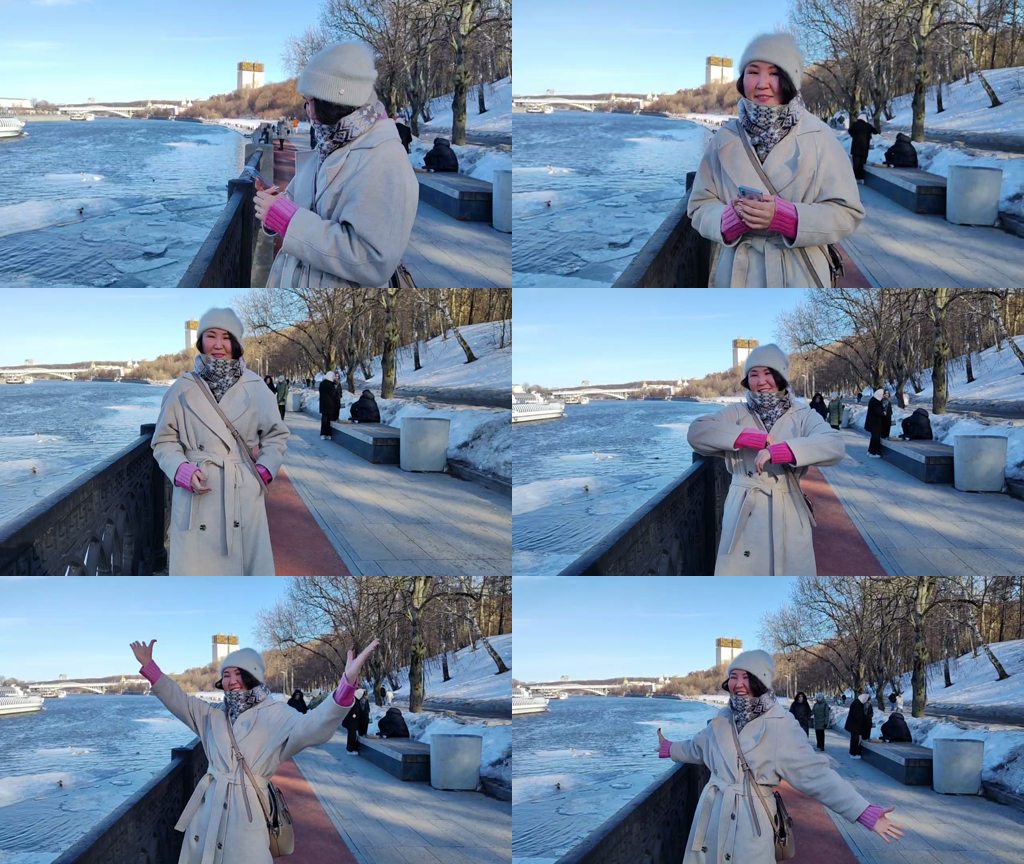

In [ ]:
grid_image

In [ ]:
num_rows, num_columns, image_filenames

(3, 2, ['frame0001.png', 'frame0019.png', 'frame0030.png', 'frame0047.png'])

In [ ]:
grid_image_path = Path("./data/video-grid/image_grid-v1-sd.png")
output_folder = Path("./data/video-keyframes/")
extract_images(grid_image_path, output_folder, num_rows, num_columns, selected_image_paths)


Resize

In [ ]:
from PIL import Image
from pathlib import Path

def resize_images(input_folder, output_folder, target_size):
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    
    for file_path in Path(input_folder).glob("*"):
        output_path = output_folder / file_path.name
        with Image.open(file_path) as image:
            image = image.resize(target_size)
            image.save(output_path)


In [ ]:
input_folder = Path("./data/video-keys-upscaled/")
output_folder = Path("./data/video-keys-fitted/")
target_size = (512, 288)

clear_folder(output_folder)
resize_images(input_folder, output_folder, target_size)

Сбор Фреймов

In [17]:
from pathlib import Path
import shutil

input_folders = sorted(Path('./data/').glob('out*'))
output_folder = Path("./data/video_eb_frames")

# Создаем выходную папку, если её нет
if not output_folder.exists():
    output_folder.mkdir()

# Очищаем папку output_folder перед использованием
def clear_folder(folder):
    for item in folder.glob("*"):
        if item.is_file():
            item.unlink()

clear_folder(output_folder)

# Настройки пересечения
overlap_ratio = 0.65

def copy_with_overlap(first_folder, second_folder, overlap_ratio):
    first_folder_files = sorted([file for file in first_folder.glob("*.png")])
    second_folder_files = sorted([file for file in second_folder.glob("*.png")])

    intersection = set(file.name for file in first_folder_files).intersection(set(file.name for file in second_folder_files))

    num_overlap_frames = int(len(intersection) * overlap_ratio)

    first_folder_overlap = sorted(list(intersection))[:num_overlap_frames]
    second_folder_overlap = sorted(list(intersection))[num_overlap_frames:]

    return first_folder_overlap, second_folder_overlap

for idx, input_folder in enumerate(input_folders[:-1]):
    next_input_folder = input_folders[idx + 1]

    first_overlap, second_overlap = copy_with_overlap(input_folder, next_input_folder, overlap_ratio)

    for file_name in first_overlap:
        src_path = input_folder / file_name
        dst_path = output_folder / file_name
        shutil.copy(str(src_path), str(dst_path))

    for file_name in second_overlap:
        src_path = next_input_folder / file_name
        dst_path = output_folder / file_name
        shutil.copy(str(src_path), str(dst_path))

# Копируем оставшиеся файлы из последней папки
for file_path in input_folders[-1].glob("*"):
    output_path = output_folder / file_path.name
    shutil.copy(str(file_path), str(output_path))


In [18]:
output_folder

WindowsPath('data/video_eb_frames')

In [19]:
import subprocess

output_video_path = Path("./data/output_video.mp4")
frame_rate = 25

command = f"ffmpeg -y -i {output_folder}/%04d.png -r {frame_rate} -filter:v \"setpts=PTS/1\" {output_video_path}"
subprocess.run(command, shell=True, check=True)


CompletedProcess(args='ffmpeg -y -i data\\video_eb_frames/%04d.png -r 25 -filter:v "setpts=PTS/1" data\\output_video.mp4', returncode=0)

RENAME FILES in DIR

In [5]:
from pathlib import Path
import re


def extract_numbers(filename):
    return ''.join(re.findall(r'\d+', filename))

def rename_files_in_directory(directory):
    file_count = 0
    directory_path = Path(directory)

    for filepath in directory_path.glob('*.png'):
        new_filename = extract_numbers(filepath.name) + '.png'
        new_filepath = filepath.with_name(new_filename)
        filepath.rename(new_filepath)
        file_count += 1

    return file_count


# Замените 'path_to_your_directory' на путь к вашей директории с файлами
directories = [
    './data/video-sq/', 
    './data/video-keys-fitted/'
]

for directory in directories:
    renamed_files = rename_files_in_directory(directory)
    print(f'В директории {directory} успешно переименовано {renamed_files} файлов.')


В директории ./data/video-sq/ успешно переименовано 235 файлов.
В директории ./data/video-keys-fitted/ успешно переименовано 6 файлов.


Перекодировать Avi после AE

In [20]:
import subprocess

def convert_avi_to_mp4(input_file, output_file, crf=23, preset='medium'):
    command = [
        "ffmpeg",
        "-i", input_file,
        "-c:v", "libx264",
        "-crf", str(crf),
        "-preset", preset,
        "-c:a", "aac",
        "-b:a", "128k",
        output_file
    ]
    subprocess.run(command, check=True)

input_avi = "./data/eb-res/Comp_1.avi"
output_mp4 = "./data/eb-res/comp_output.mp4"

convert_avi_to_mp4(input_avi, output_mp4)


Черновики

In [ ]:
from pathlib import Path
from PIL import Image
import math

def create_grid(input_folder, num_rows=None):
    image_paths = sorted([p for p in input_folder.glob("*.png")])
    image_filenames = [p.name for p in image_paths]

    images = [Image.open(p) for p in image_paths]
    width, height = images[0].size
    
    if num_rows is None:
        grid_size = int(math.ceil(math.sqrt(len(images))))
        num_rows = grid_size
    else:
        grid_size = int(math.ceil(len(images) / num_rows))
        
    num_columns = grid_size
    grid_width = num_columns * width
    grid_height = num_rows * height
    grid_image = Image.new("RGB", (grid_width, grid_height))

    for i, image in enumerate(images):
        x = (i % num_columns) * width
        y = (i // num_columns) * height
        grid_image.paste(image, (x, y))

    return grid_image, num_rows, num_columns, image_filenames

input_folder = Path("./data/video-keys/")
grid_image, num_rows, num_columns, image_filenames = create_grid(input_folder)

output_image_path = "./data/video-grid/image_grid-v1.png"
grid_image.save(output_image_path)
